# Dropout Proportion z-Tests

I noticed when doing [dropout visualizations](https://nbviewer.jupyter.org/gist/g-eoj/5097c1277359f8b1f8af763ea0163084) that the proportion of the output elements dropped did not equal the dropout rate. I wanted to see if a hypothesis test would detect a significant difference between the dropout rate argument and the proportion of dropped elements. 

The TensorFlow [documentation](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) for dropout says each component (as defined by `noise_shape`) is dropped independently. Then dropout is based on a Bernoulli trial for each component individually, rather than randomly selecting from all components. So the count of dropped components is a random variable with a binomial distribution.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np

from keras import layers
from keras.models import Model
from scipy.stats import binom
from scipy.stats import norm

%matplotlib inline

keras_version = keras.__version__
tf_version = keras.backend.tensorflow_backend.tf.VERSION

print("keras version:", keras_version)
print(keras.backend.backend(), "version:", tf_version)

Using TensorFlow backend.


keras version: 2.2.2
tensorflow version: 1.10.0


#### Test Function
A z-test is appropriate because a binomial distribution can be [approximated](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) by a normal distrbution, if the sample size is large enough.

In [2]:
def dropout_rate_ztest(k, n, p_0, alpha=0.05):
    """One proportion z-test for whether the true dropout rate 
    is equal to the dropout rate argument. Also plots a
    binomial distribution based on the given inputs.
    
    # Arguments
        k: count of dropped outputs
        n: count of all outputs (sample size)
        p_0: dropout rate argument
        alpha: significance level
        
    When specifying the counts (`k` and `n`), consider the `noise_shape` 
    argument to dropout. For example, if `noise_shape=(64,1,1,32)` 
    after a 2D convolution layer, for each sample and each channel the 
    entire spatial dimensions get dropped, and should only contribute one 
    to the counts. In this case you could calculate counts like so:
    
        component_shape = np.divide(output.shape, noise_shape) 
        not_dropped_count = np.count_nonzero(output) / np.prod(component_shape)
        k = np.prod(noise_shape) - not_dropped_count,
        n = np.prod(noise_shape)
    """
    
    p_hat = k / n
    
    if p_hat * n < 9 or (1 - p_hat) * n < 9:
        print("Assumptions for z-test not met. Increase sample size.")
        return
    
    z = (p_hat - p_0) / (np.sqrt(p_0 * (1 - p_0) / n))
    p_value = norm.cdf(-np.abs(z)) * 2  

    print("Null Hypothesis: true dropout rate =", p_0)
    print("Alternative Hypothesis: true dropout rate \u2260", p_0)
    print("Sample Size:", n)
    print("Sample Proportion:", p_hat)
    print("Test Statistic:", z)
    print("p-value:", p_value)

    if p_value < alpha:
        print("\nReject the null hypothesis. There is sufficient evidence to conclude")
        print("the true dropout rate is not ", p_0, " at a significance level of ", alpha, ".", sep='')
    else:
        print("\nFail to reject the null hypothesis. There is insufficient evidence to conclude") 
        print("the true dropout rate is not ", p_0, " at a significance level of ", alpha, ".", sep='')

    fig, ax = plt.subplots(1, 1)
    x = np.arange(binom.ppf(0.01, n, p_0), binom.ppf(0.99, n, p_0))
    ax.set_title("Binomial Distribution for n = " + str(n) + " and p = " + str(p_0))
    ax.plot(x, binom.pmf(x, n, p_0), 'black', ms=2)
    ax.vlines(x, 0, binom.pmf(x, n, p_0), colors='gray', lw=5, alpha=0.33)
    ax.vlines(k, 0, binom.pmf(k, n, p_0), colors='r', lw=2, alpha=1.0)
    ax.annotate('dropped count', xy=(k, 0), xytext=(0.5, 0.2), 
                textcoords='axes fraction', horizontalalignment='center',
                arrowprops=dict(facecolor='black', width=2, shrink=0.05));

## Hypothesis Tests

I detect dropped elements by counting the number of zeroes in the model ouput, so I'm careful to create input data and models that won't output zeroes when dropout isn't used.

### Regular Dropout after Dense Layer

https://keras.io/layers/core/#dropout

Null Hypothesis: true dropout rate = 0.5
Alternative Hypothesis: true dropout rate ≠ 0.5
Sample Size: 6400
Sample Proportion: 0.50515625
Test Statistic: 0.8249999999999957
p-value: 0.40937159069450757

Fail to reject the null hypothesis. There is insufficient evidence to conclude
the true dropout rate is not 0.5 at a significance level of 0.05.


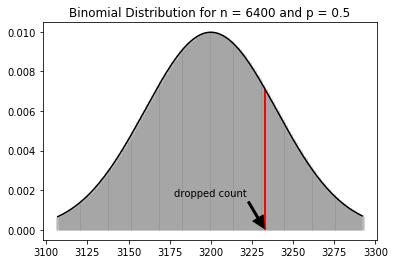

In [3]:
batch_size = 64
units = 100
dropout_rate = 0.5

examples = np.ones(shape=(batch_size,1), dtype=float)

inputs = layers.Input(shape=examples.shape[1:])
x = layers.Dense(
    units=units,
    activation=None,
    use_bias=False,
    kernel_initializer=keras.initializers.Ones())(inputs)
x = layers.Dropout(rate=dropout_rate)(x, training=True)

output = Model(inputs=inputs, outputs=x).predict(examples, batch_size=batch_size)
    
dropout_rate_ztest(
    k=np.prod(output.shape) - np.count_nonzero(output), # count of dropped outputs
    n=np.prod(output.shape), # sample size
    p_0=dropout_rate)

### SpatialDropout2D after 2D Convolution Layer

https://keras.io/layers/core/#spatialdropout2d

Note that `SpatialDropout2D()` is equivalent to `Dropout()` with `noise_shape=(batch_size, 1, 1, filters)` when using channels last data format. See [source code](https://github.com/keras-team/keras/blob/master/keras/layers/core.py#L177).

Null Hypothesis: true dropout rate = 0.5
Alternative Hypothesis: true dropout rate ≠ 0.5
Sample Size: 2048
Sample Proportion: 0.48974609375
Test Statistic: -0.9280776503073436
p-value: 0.35336729199329187

Fail to reject the null hypothesis. There is insufficient evidence to conclude
the true dropout rate is not 0.5 at a significance level of 0.05.


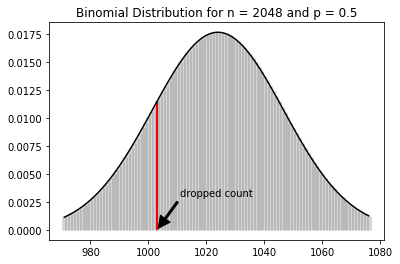

In [4]:
batch_size = 64
height = 28
width = 28
channels = 1
filters = 32
dropout_rate = 0.5

examples = np.ones(shape=(batch_size, height, width, channels), dtype=float)
noise_shape = (batch_size, 1, 1, filters) # noise_shape used by keras.layers.SpatialDropout2D()

inputs = layers.Input(shape=examples.shape[1:])
x = layers.Conv2D(
    filters=filters,
    kernel_size=5,
    padding='same',
    activation=None,
    use_bias=False,
    kernel_initializer=keras.initializers.Ones())(inputs)
x = layers.SpatialDropout2D(rate=dropout_rate)(x, training=True)

output = Model(inputs=inputs, outputs=x).predict(examples, batch_size=batch_size)

# Since noise_shape causes dropout to select groups of points (components)
# instead of individual points, we want to divide by the component size 
# so as not to overcount. In the case of SpatialDropout2D, 
# the spatial dimensions (height * width) define component size.
component_shape = np.divide(output.shape, noise_shape) 
not_dropped_count = np.count_nonzero(output) / np.prod(component_shape)

dropout_rate_ztest(
    k=np.prod(noise_shape) - not_dropped_count,
    n=np.prod(noise_shape), # true sample size / same as component count
    p_0=dropout_rate)